## Estimación de viviendas para gobierno federal de Claudia Sheinbaum

In [216]:
##Borrar datos del entorno
rm(list=ls())


#Directorio para descargar de datos
#Esto se debe de cambiar en cada computadora
#setwd("D:/datos")
#creamos carpeta en donde almacenaremos los archivos
dir.create("envi", showWarnings = F)

In [217]:

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, srvyr,kableExtra, webshot,gt,magick,showtext)
#Fuente para los gráficos
font_add_google("Poppins", "pop")
showtext_auto()

In [218]:
#Descarga de archivos====
url<-"https://www.inegi.org.mx/contenidos/programas/envi/2020/microdatos/envi_2020_base_de_datos_csv.zip"

temp <- tempfile()
download.file(url,
              mode = "wb",
              destfile = temp)
unzip(temp, exdir = "envi") 
unlink(temp)

In [219]:
vivienda<-read.csv("envi/Bases de datos/TVIVIENDA.csv")%>%
  janitor::clean_names()%>%
    #renombrar
  rename(folio=1,
    tot_resid=p1_1,
    num_cuarto=p4_10a,
    mat_pared=p4_4,
    mat_pisos=p4_6,
    mat_techos=p4_5,
excusado=p4_11)%>%
    mutate(
    mat_pared = as.numeric(mat_pared),
    mat_pisos = as.numeric(mat_pisos),
    mat_techos = as.numeric(mat_techos),
#Calcular rezago habitacional
    rezago = case_when(
      (tot_resid / num_cuarto) > 2.5 |   # Hacinamiento
        mat_pared %in% c(1, 2, 3, 4, 5, 6) |
        mat_pisos %in% c(1) |
        mat_techos %in% c(1, 2, 3, 4, 6, 7, 9) |
        excusado == 2 ~ "En rezago",
      TRUE ~ "Fuera de rezago"
    ))

In [220]:
vivirezago<-vivienda%>%
filter(rezago=="En rezago")%>%
select(folio,viv_sel,rezago)

In [221]:
#Obtener ingreso del hogar
ingreso<-read.csv("envi/Bases de datos/TSDEM.csv")%>%
    janitor::clean_names()%>%
    #renombrar
    rename(folio=1,
ingreso=p3_4)%>%
#Normalizar a ingreso mensual
mutate(ingreso=
case_when(
#A la semana
p3_4a==1~ingreso*30.4,
#A la quincena
p3_4a==2~ingreso*2,
#Al año
p3_4a==4~ingreso/12,
TRUE~ingreso
)
)%>%
#Colapsar por hogar
group_by(folio,viv_sel,hogar)%>%
summarise(ingreso=sum(ingreso))%>%
#Filtrar aquellos con ingreso diferente a NAN
filter(!is.na(ingreso))%>%
#Clasificar por rangos de umas
#Menor a 2.5 umas mensuales
mutate(ingreso_cat=
case_when(
ingreso<108.57*30.4*2.5~"Menos de 2.5 umas",
ingreso>=108.57*30.4*2.5 & ingreso<108.57*30.4*5~"De 2.5 a 5 umas",
#Mayor a 5 umas
ingreso>=108.57*30.4*5~"Más de 5 umas"
)
)

`summarise()` has grouped output by 'folio', 'viv_sel'. You can override using
the `.groups` argument.


In [222]:
#Leer demanda de vivienda
demanda<-read.csv("envi/Bases de datos/TDEMANDA.csv")%>%
  janitor::clean_names()%>%
  #renombrar
  rename(folio=1)%>%
#Pegar viviendas en rezago e ingresos
left_join(vivirezago,by=c("folio","viv_sel"))%>%
left_join(ingreso,by=c("folio","viv_sel","hogar"))%>%
###############################
#Criterios de discriminación####
###############################


#Filtrar aquellos en rezago
filter(rezago=="En rezago")%>%
#Filtrar aquellos que tienen intención de comprar o construir
filter(p3a4 %in% c(2,3,4))%>%
#Discriminar por motivos
filter(p3a6 %in% c(5,3,6,7,8,4))%>%
#Discriminar por valor de la vivienda. Dejar solo aquellas que serán de interés social Menor a 1 millón 100 mil pesos
filter(p3a9 %in% c(1,2,3,4))%>%

#Crear nombre de entidad
mutate(nom_ent=case_when(
ent==1~"Aguascalientes",
ent==2~"Baja California",
ent==3~"Baja California Sur",
ent==4~"Campeche",
ent==5~"Coahuila de Zaragoza",
ent==6~"Colima",
ent==7~"Chiapas",
ent==8~"Chihuahua",
ent==9~"Ciudad de México",
ent==10~"Durango",
ent==11~"Guanajuato",
ent==12~"Guerrero",
ent==13~"Hidalgo",
ent==14~"Jalisco",
ent==15~"México",
ent==16~"Michoacán de Ocampo",
ent==17~"Morelos",
ent==18~"Nayarit",
ent==19~"Nuevo León",
ent==20~"Oaxaca",
ent==21~"Puebla",
ent==22~"Querétaro",
ent==23~"Quintana Roo",
ent==24~"San Luis Potosí",
ent==25~"Sinaloa",
ent==26~"Sonora",
ent==27~"Tabasco",
ent==28~"Tamaulipas",
ent==29~"Tlaxcala",
ent==30~"Veracruz de Ignacio de la Llave",
ent==31~"Yucatán",
ent==32~"Zacatecas"))

In [223]:

options(survey.lonely.psu="certainty")

dism <-demanda%>%
  as_survey_design(ids=upm_dis,
                   strata=est_dis,
                   weights=factor)

In [224]:
tabla<-dism%>%
group_by(nom_ent)%>%
    summarise(viviendas=survey_total(vartype="cv"),
              pct=survey_prop(vartype="cv"))%>%

    arrange(desc(viviendas))%>%
    janitor::adorn_totals("row")%>%
select(nom_ent,viviendas,pct)%>%
mutate(pct=round(pct*100,2))

#Salvar excel

openxlsx::write.xlsx(tabla,"vivi_const_entidad.xlsx")

print(paste(
  "Total de viviendas que podría construir el Gobierno Federal:",
  format(tabla %>% filter(nom_ent == "Total") %>% pluck("viviendas"), big.mark = ",")
))


[1] "Total de viviendas que podría construir el Gobierno Federal: 1,142,461"


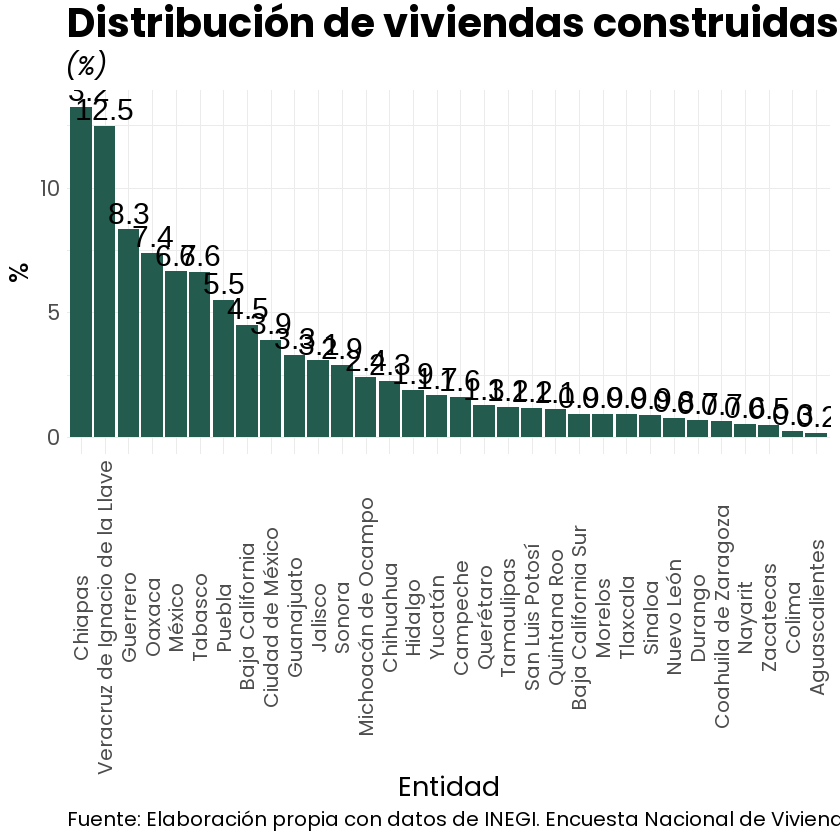

In [225]:
#Hacer gráfica de barras
tabla%>%
filter(nom_ent!="Total")%>%
ggplot(aes(x=reorder(nom_ent,-pct),y=pct))+
geom_col(fill="#235B4E")+
geom_text(aes(label=round(pct,1)),position=position_dodge(width=0.9),vjust=-0.3,size=8,color="black")+
theme_minimal()+
labs(
    title="Distribución de viviendas construidas por el Gobierno Federal por entidad federativa, 2024-2030",
    subtitle="(%)",
    caption="Fuente: Elaboración propia con datos de INEGI. Encuesta Nacional de Vivienda 2020.",
    x="Entidad",
    y="%")+
theme(
    plot.title = element_text(hjust = 0, size=30,face="bold"),
    plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
    plot.caption = element_text(hjust = 0,size=15),
    axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
    text=element_text("pop",size=20))

ggsave("vivi_const_entidad.png",width=22,height=13, dpi=100, bg="white")